<ipython-input-5-028e32ea94f5>:60: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  actual_num  = np.float(nums.split('_')[0])


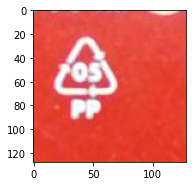

In [5]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


resolution = [128,128, 3]

source_dir = 'datasets'



def plot_img(img_matrix):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    
    ax1.imshow(img_matrix.astype('uint8'))

    plt.show()

def get_result(prediction):
    return np.argmax(prediction)

def procces_img(path):
    img_tmp = Image.open(path).resize((resolution[0],resolution[1]))
    return np.array(img_tmp).astype('uint8')

def get_matrix_data(data, resolution, num):

    x_data = []

    for img in data:

        img_matrix = procces_img(f'{source_dir}/{int(num)}/{img}')
        
        x_data.append(img_matrix)
    
    return x_data



def transfrom_data(ratio, source_dir, resolution):

    tmp_train_x = []
    tmp_valid_x = []
    tmp_test_x = []

    train_dataset_x = np.array([])
    valid_dataset_x = np.array([])
    test_dataset_x = np.array([])

    train_dataset_y = np.array([])
    valid_dataset_y = np.array([])
    test_dataset_y = np.array([])

    for nums in  os.listdir(source_dir):

        actual_num  = np.float(nums.split('_')[0])
        
        data = os.listdir(source_dir + '/' + nums)

        # for random take test, train and valid data
        random.shuffle(data)
        
        tmp_train_x.extend(get_matrix_data(data[:int(len(data) * ratio[0])], resolution, actual_num))
        train_dataset_y = np.append(train_dataset_y, np.full((1, int(len(data) * ratio[0])), actual_num))

        tmp_valid_x.extend(get_matrix_data(data[int(len(data) * ratio[0]): int(len(data) * (ratio[0] + ratio[1]))], resolution, actual_num))
        valid_dataset_y = np.append(valid_dataset_y, np.full((1, int(len(data) * (ratio[0] + ratio[1])) - int(len(data) * ratio[0])), actual_num))

        tmp_test_x.extend(get_matrix_data(data[-int(len(data) * ratio[2]):], resolution, actual_num))
        test_dataset_y = np.append(test_dataset_y, np.full((1, int(len(data) * ratio[2])), actual_num))

    train_dataset_x = np.append(train_dataset_x, tmp_train_x)
    train_dataset_x = train_dataset_x.reshape((train_dataset_y.shape[0], resolution[0],resolution[1], 3))

    valid_dataset_x = np.append(valid_dataset_x, tmp_valid_x)
    valid_dataset_x =  valid_dataset_x.reshape((valid_dataset_y.shape[0], resolution[0],resolution[1], 3))

    test_dataset_x = np.append(test_dataset_x ,tmp_test_x)
    test_dataset_x = test_dataset_x.reshape((test_dataset_y.shape[0], resolution[0],resolution[1], 3))

    return {'x': train_dataset_x, 'y': train_dataset_y}, {'x': valid_dataset_x, 'y': valid_dataset_y}, {'x': test_dataset_x, 'y': test_dataset_y}
            
train, valid, test = transfrom_data([0.8, 0.1, 0.1], source_dir, resolution)

plot_img(train['x'][1000])


In first we are trying to loa data from source dir.
Note this was before i found out that tensorflow has own library for proccesing data from dirs

loading needed libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D
from keras import backend as K

# loading preprocessed model
baseModel = tf.keras.applications.MobileNetV2(input_shape=(resolution[0], resolution[1], resolution[2]), weights='imagenet', include_top=False, classes=8)


In [3]:
## dont want to train pretrained layer, starting from last
for layers in baseModel.layers[:-6]:
  layers.trainable=False

### starting from last layer of pretraindef model
last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

Epoch 1/50
289/289 [==============================] - 101s 350ms/step - loss: 4.8314 - accuracy: 0.5715 - val_loss: 5.0166 - val_accuracy: 0.4597
Epoch 2/50
289/289 [==============================] - 100s 345ms/step - loss: 4.4874 - accuracy: 0.5801 - val_loss: 4.9403 - val_accuracy: 0.4528
Epoch 3/50
289/289 [==============================] - 99s 343ms/step - loss: 4.4813 - accuracy: 0.5809 - val_loss: 4.7253 - val_accuracy: 0.5723
Epoch 4/50
289/289 [==============================] - 102s 352ms/step - loss: 4.3840 - accuracy: 0.5840 - val_loss: 4.6964 - val_accuracy: 0.5541
Epoch 5/50
289/289 [==============================] - 100s 344ms/step - loss: 4.3628 - accuracy: 0.5851 - val_loss: 4.5070 - val_accuracy: 0.5775
Epoch 6/50
289/289 [==============================] - 100s 346ms/step - loss: 4.2529 - accuracy: 0.5893 - val_loss: 4.3940 - val_accuracy: 0.4320
Epoch 7/50
289/289 [==============================] - 104s 358ms/step - loss: 4.1973 - accuracy: 0.5877 - val_loss: 4.2053 - 

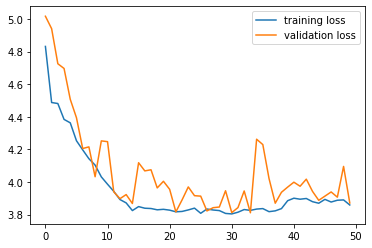

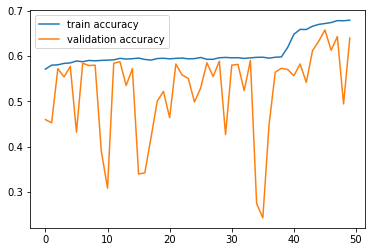

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
history = model.fit(train['x'], train['y'], validation_data=(valid['x'], valid['y']), epochs=epochs)

plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

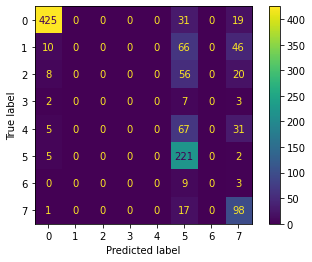

In [13]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


def get_result(prediction):
    return np.argmax(prediction)

predicted = []
counter = 0
for img in test['x']:
    prediction = model.predict(img.reshape((-1, resolution[0], resolution[1], resolution[2])))
    predicted.append(get_result(prediction))

confusion_matrix = metrics.confusion_matrix(test['y'], np.array(predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0','1','2','3','4','5','6','7'])

cm_display.plot()
plt.show()